In [ ]:
!pip install wget
!pip install transformers

In [115]:
!pip3 install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 11.3 MB/s eta 0:00:00


In [116]:
import os
import time
import datetime
import random
from google.colab import drive

import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import IPython

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torcheval.metrics import MulticlassPrecisionRecallCurve

In [118]:
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Empty cache of GPU
torch.cuda.empty_cache()

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Load data

In [64]:
train_df = pd.read_csv("train.csv").sample(n=40000, ignore_index=True)
val_df = pd.read_csv("val.csv").sample(n=5000, ignore_index=True)
test_df = pd.read_csv("test.csv").sample(n=5000, ignore_index=True)

In [71]:
def text_n_labels(df) :
  texts = df['Text'].values
  label_cats = df['Class'].astype('category').cat

  # List of label names (str)
  label_names = label_cats.categories

  # List of label ids (int, in range (0,num_classes-1))
  labels = label_cats.codes
  return texts, labels, label_names

In [72]:
train_text, train_labels, label_names = text_n_labels(train_df)
val_text, val_labels, _ = text_n_labels(val_df)
test_text, test_labels, _ = text_n_labels(val_df)

In [73]:
label_names

Index(['Human', 'M-BART', 'M-BART50', 'M2M-100', 'OPUS-MT', 'mT5-Large',
       'mT5-Small', 'ruGPT2-Large', 'ruGPT3-Large', 'ruGPT3-Medium',
       'ruGPT3-Small', 'ruT5-Base', 'ruT5-Base-Multitask', 'ruT5-Large'],
      dtype='object')

## Tokenize Data

In [74]:
model_name = "bert-base-multilingual-cased"
MAX_INPUT_LENGTH = 192

In [75]:
# Load the pretrained BERT tokenizer.
print(f"Loading {model_name} tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading bert-base-multilingual-cased tokenizer...


In [77]:
# Tokenize all of the sentences and map the tokens to their word IDs
def tokenize(texts):
  input_ids = []
  attention_masks = []

  for text in texts:
      encoded_dict = tokenizer.encode_plus(
                          text,            
                          add_special_tokens = True,
                          max_length = MAX_INPUT_LENGTH,
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt')
    
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

In [86]:
train_input_ids, train_attention_masks = tokenize(train_text)
val_input_ids, val_attention_masks = tokenize(val_text)
test_input_ids, test_attention_masks = tokenize(test_text)

In [87]:
# Convert the lists into tensors.
input_ids = torch.cat(train_input_ids, dim=0)
attention_masks = torch.cat(train_attention_masks, dim=0)
labels = torch.tensor(train_labels, dtype=torch.long)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_text[0])
print('Token IDs:', train_input_ids[0])
print('Attention Mask:', train_attention_masks[0]) # 1 for all text tokens, 0 for all padding tokens

Original:  Названы быки, в которых нашли незнакомые и совхозные коровы, пришедшие с ножом похитились как живыми быками.
Token IDs: tensor([[  101, 87348, 11307, 22504, 10648,   117,   543, 15496, 79590, 10783,
         10375, 45572, 13393, 14578,   549, 98903, 71169, 11194, 80062, 75003,
           117, 10913, 13391, 10746, 23352,   558, 11279, 52834, 10241, 10297,
         22710, 99982, 19935, 10949, 78736, 21473, 22504, 18697,   119,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


In [88]:
# Convert the lists into tensors.
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels, dtype=torch.long)

<ipython-input-88-967f4a8bc6cc>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels, dtype=torch.long)


In [89]:
# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels, dtype=torch.long)

<ipython-input-89-1ad87b17828a>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels, dtype=torch.long)


In [90]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
# # Create a 80-10-10 train-validation-test split

# # Calculate the number of samples to include in each set.
# train_size = int(0.8 * len(dataset))
# val_size = int(0.1 * len(dataset)) 
# test_size = len(dataset) - train_size - val_size

# # Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# print(f"{train_size} training samples")
# print(f"{val_size} validation samples")
# print(f"{test_size} test samples")

In [91]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# For test the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

## Create and Train Model

In [92]:
# Load pretrained model for sequence classification
print(f"Loading {model_name} model...")
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(label_names)
config.output_attentions = True
print("config", config)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config)

Loading bert-base-multilingual-cased model...
config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  

In [93]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,

In [94]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [96]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [97]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [98]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [99]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # (loss, logits, attentions) = model(input_ids=b_input_ids, 
        #                                  attention_mask=b_input_mask, 
        #                                  labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(input_ids=b_input_ids, 
                                         attention_mask=b_input_mask, 
                                         labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,500.    Elapsed: 0:00:23.
  Batch    80  of  2,500.    Elapsed: 0:00:47.
  Batch   120  of  2,500.    Elapsed: 0:01:11.
  Batch   160  of  2,500.    Elapsed: 0:01:34.
  Batch   200  of  2,500.    Elapsed: 0:01:57.
  Batch   240  of  2,500.    Elapsed: 0:02:21.
  Batch   280  of  2,500.    Elapsed: 0:02:44.
  Batch   320  of  2,500.    Elapsed: 0:03:08.
  Batch   360  of  2,500.    Elapsed: 0:03:31.
  Batch   400  of  2,500.    Elapsed: 0:03:55.
  Batch   440  of  2,500.    Elapsed: 0:04:18.
  Batch   480  of  2,500.    Elapsed: 0:04:42.
  Batch   520  of  2,500.    Elapsed: 0:05:06.
  Batch   560  of  2,500.    Elapsed: 0:05:29.
  Batch   600  of  2,500.    Elapsed: 0:05:53.
  Batch   640  of  2,500.    Elapsed: 0:06:16.
  Batch   680  of  2,500.    Elapsed: 0:06:40.
  Batch   720  of  2,500.    Elapsed: 0:07:03.
  Batch   760  of  2,500.    Elapsed: 0:07:27.
  Batch   800  of  2,500.    Elapsed: 0:07:50.
  Batch   840  of

In [100]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.30,1.26,0.54,0:24:30,0:01:05
2,1.07,1.27,0.56,0:24:30,0:01:05
3,0.86,1.35,0.56,0:24:21,0:01:05


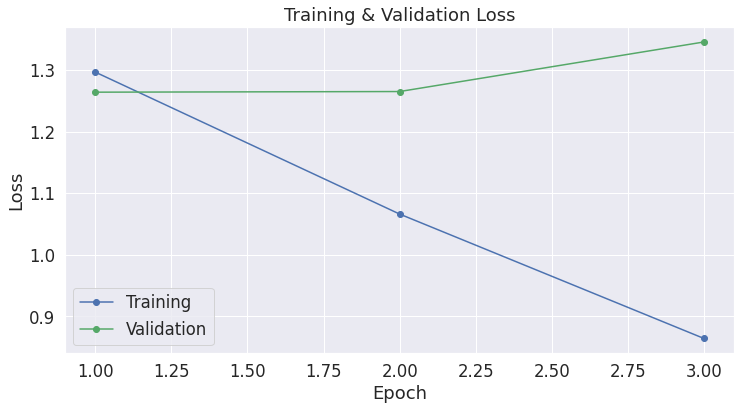

In [102]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.show()

## Evaluation on Test Set

In [111]:
# Prediction on test set
from sklearn.metrics import precision_recall_curve

print("Predicting labels ...")

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
precisions = []
recalls = []


# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(input_ids=b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  
  # Move logits and labels to CPU
  logits = logits.detach().cpu()
  label_ids = b_labels.to('cpu')
  pr_curve = PrecisionRecallCurve(task="multiclass", num_classes=14)
  precision, recall, thresholds = pr_curve(logits, label_ids)
  precisions.extend(precision)
  recalls.extend(recall)
  # Store predictions and true labels
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.extend(logits)
  true_labels.extend(label_ids)

print(f"Predicted {len(predictions)} samples")

Predicting labels ...
Predicted 5000 samples


In [112]:
predictions = np.argmax(predictions, axis=1)
print(f"Test set accuracy: {accuracy_score(true_labels, predictions)}")

Test set accuracy: 0.5566


In [122]:
report = classification_report(true_labels, predictions, output_dict=True)
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1963
           1       0.57      0.58      0.57        99
           2       0.43      0.55      0.49       442
           3       0.20      0.18      0.19       402
           4       0.32      0.44      0.37       507
           5       0.28      0.23      0.25       185
           6       0.43      0.19      0.27       120
           7       0.56      0.53      0.55        86
           8       0.57      0.50      0.53       388
           9       0.47      0.41      0.44       264
          10       0.57      0.47      0.51       294
          11       0.50      0.66      0.57        91
          12       0.39      0.07      0.12        96
          13       0.12      0.05      0.07        63

    accuracy                           0.56      5000
   macro avg       0.44      0.40      0.41      5000
weighted avg       0.55      0.56      0.55      5000



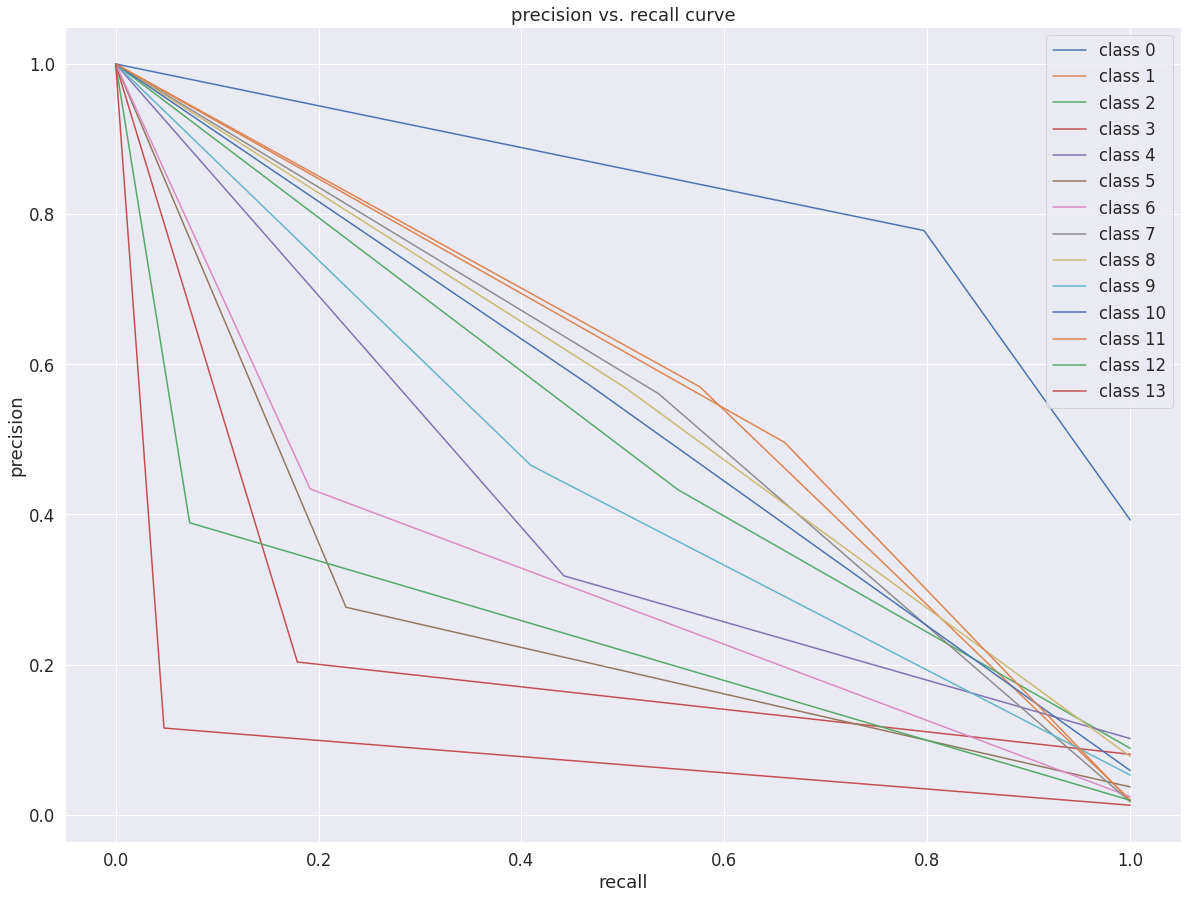

In [145]:
precision = {}
recall = {}
plt.rcParams["figure.figsize"] = (20,15)
for i in range(14):
    ith_labels = [1 if j == i else 0 for j in true_labels]
    ith_preds = [1 if j == i else 0 for j in predictions]
    precision[i], recall[i], _ = precision_recall_curve(ith_labels,
                                                        ith_preds)
    # precision[i] = report[f'{i}']['precision']
    # recall[i] = report[f'{i}']['recall']
    plt.plot(recall[i], precision[i], label='class {}'.format(i))
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision Recall Curve")
plt.show()

In [142]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = f"./{model_name}/"

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving model to {output_dir}")

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./bert-base-multilingual-cased/


('./bert-base-multilingual-cased/tokenizer_config.json',
 './bert-base-multilingual-cased/special_tokens_map.json',
 './bert-base-multilingual-cased/vocab.txt',
 './bert-base-multilingual-cased/added_tokens.json',
 './bert-base-multilingual-cased/tokenizer.json')